# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende del tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.
 
 # Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

# ¡Comencemos!

  A continuación dejamos un ejemplo de cómo extraer el $k$ inicial de Argentina, usando un ajuste de cuadrados mínimos. Si necesitas los datos mundiales, en la columna de países aparecen como "World".



In [1]:
import numpy as np
import pandas as pd
import pylab as plt
#from google.colab import drive
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
datos=pd.read_csv('C:/Users/Admin/Desktop/Data Science/Sprint 4/Sprint Project/covid-tests-cases-deaths-project.csv')
datos.head()


,Entity,Code,Day,total_tests,142601-annotations,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19
0,Afghanistan,AFG,2020-03-23,NaN,NaN,1.0,40.0
1,Afghanistan,AFG,2020-03-24,NaN,NaN,1.0,42.0
2,Afghanistan,AFG,2020-03-25,NaN,NaN,1.0,74.0
3,Afghanistan,AFG,2020-03-26,NaN,NaN,2.0,80.0
4,Afghanistan,AFG,2020-03-27,NaN,NaN,2.0,91.0


a. Explora la fuente de datos: ¿qué representa el dataset? ¿Hay información sobre las columnas?

In [3]:
datos.dtypes

Entity                                     object
Code                                       object
Day                                        object
total_tests                               float64
142601-annotations                         object
Total confirmed deaths due to COVID-19    float64
Total confirmed cases of COVID-19         float64
dtype: object

In [4]:
# Veo filas y columnas
datos.shape

print("El dataset tiene",datos.shape[0], "filas.")
print("El dataset tiene",datos.shape[1], "columnas.")

El dataset tiene 136172 filas.
El dataset tiene 7 columnas.


In [5]:
# Vemos la clasificación en países
datos.Entity.unique()

print("Hay un total de:", len(datos.Entity.unique()), " clasificaciones de paises")

#paises= datos.Entity.unique()
#for pais in paises:
#    print(pais)

Hay un total de: 215  clasificaciones de paises


In [6]:
#Analizamos algunos datos
print("Total de muertes confirmadas:", max(datos["Total confirmed deaths due to COVID-19"]))

print("Total de casos confirmados:", max(datos["Total confirmed cases of COVID-19"]))

Total de muertes confirmadas: 5295886.0
Total de casos confirmados: 269176282.0


In [7]:
paises=datos['Entity'] #cargo el vector de paises
confirmados=datos['Total confirmed cases of COVID-19'] #carga vector todos los casos confirmados

El dataset muestra la cantidad de casos y muertes confirmados por COVID-19 distribuidos por país y fecha. Las columnas se encuentran identificadas y son claras en lo que representan.  

b. Realiza un análisis exploratorio que incluya:
 * Tomar datos de un país en particular 
 * Seleccionar la etapa de primer crecimiento exponencial de la curva
 * Extraer el k de crecimiento exponencial y comparar el modelo con los datos reales para distintos países.
 * Generar un intervalo de confianza para el valor de k midiéndolo para varios países con el objetivo de representar la población mundial con la selección que hagas

Text(0, 0.5, 'cantidad de casos')

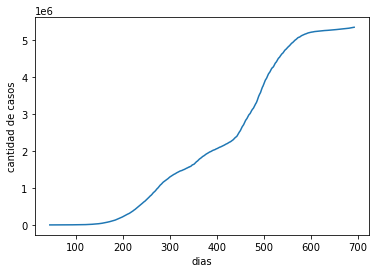

In [8]:
#Seleccionamos Argentina

ind_arg=np.where(paises=='Argentina')
ind_arg=ind_arg[0]
casos_arg=confirmados[ind_arg]
dias=np.arange(0,len(casos_arg))
plt.plot(dias,casos_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

In [9]:
arg =  datos[datos['Entity'] == 'Argentina']
arg.head()

,Entity,Code,Day,total_tests,142601-annotations,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19
4550,Argentina,ARG,2020-01-01,4.0,tests performed,NaN,NaN
4551,Argentina,ARG,2020-01-02,53.0,tests performed,NaN,NaN
4552,Argentina,ARG,2020-01-03,58.0,tests performed,NaN,NaN
4553,Argentina,ARG,2020-01-04,133.0,tests performed,NaN,NaN
4554,Argentina,ARG,2020-01-05,146.0,tests performed,NaN,NaN


In [10]:
#Vemos si existen valores faltantes
arg['Total confirmed cases of COVID-19'].isna()

4550     True
4551     True
4552     True
4553     True
4554     True
        ...  
5238    False
5239    False
5240    False
5241    False
5242    False
Name: Total confirmed cases of COVID-19, Length: 693, dtype: bool

In [11]:
# Se analiza en qué índice se ubican los valores faltantes
val_falt= np.where(arg['Total confirmed cases of COVID-19'].isnull())[0]
val_falt

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], dtype=int64)

Esta es la curva de **casos totales** de la Argentina. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

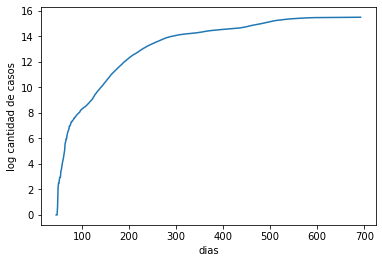

In [12]:
plt.plot(dias,np.log(casos_arg))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Argentina, para ver cómo fue el $k$ inicial

Text(0, 0.5, 'cantidad de casos')

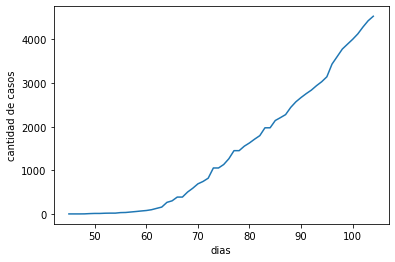

In [13]:
#casos_principio=casos_arg[0:60]
#dias_principio=dias[0:60]
casos_principio=casos_arg[45:105]
dias_principio=dias[45:105]


plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

In [14]:
casos_principio

4595       1.0
4596       1.0
4597       1.0
4598       2.0
4599       8.0
4600      12.0
4601      12.0
4602      17.0
4603      19.0
4604      19.0
4605      31.0
4606      34.0
4607      45.0
4608      56.0
4609      68.0
4610      79.0
4611      97.0
4612     128.0
4613     158.0
4614     266.0
4615     301.0
4616     387.0
4617     387.0
4618     502.0
4619     589.0
4620     690.0
4621     745.0
4622     820.0
4623    1054.0
4624    1054.0
4625    1133.0
4626    1265.0
4627    1451.0
4628    1451.0
4629    1554.0
4630    1628.0
4631    1715.0
4632    1795.0
4633    1975.0
4634    1975.0
4635    2142.0
4636    2208.0
4637    2277.0
4638    2443.0
4639    2571.0
4640    2669.0
4641    2758.0
4642    2839.0
4643    2941.0
4644    3031.0
4645    3144.0
4646    3435.0
4647    3607.0
4648    3780.0
4649    3892.0
4650    4003.0
4651    4127.0
4652    4285.0
4653    4428.0
4654    4532.0
Name: Total confirmed cases of COVID-19, dtype: float64

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

Text(0, 0.5, 'log cantidad de casos')

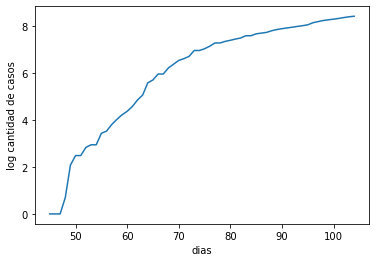

In [15]:

plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Mejor nos quedamos con lo que sucede entre los días 50 y 75, ya que ese fue el comportamiento más sostenido.

Text(0, 0.5, 'cantidad de casos')

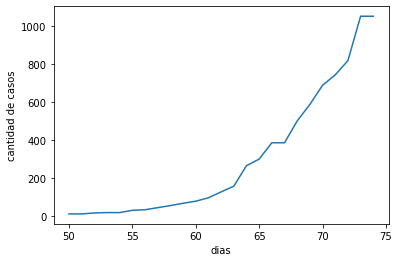

In [16]:
casos_principio=casos_arg[50:75]
dias_principio=dias[50:75]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

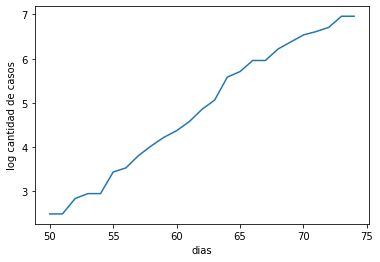

In [17]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

¡Se ve bastante lineal! Aprovechemos esto para averiguar el $k$ utilizando un ajuste hecho con el método de cuadrados mínimos, ajustando los datos al modelo 

$Confirmados=e^{k(t-t_0)}$



In [18]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
    C=np.exp(k*(t-t0))
    return C

In [19]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([ 0.1566142 , 28.94357129])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

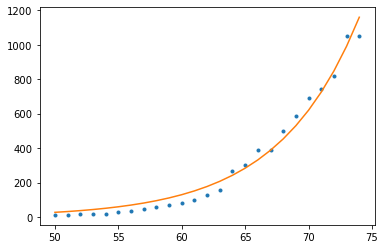

In [20]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Como última pista, hagamos una función que determine los casos nuevos por día a partir de estas curvas. Puede ser útil para tu análisis.

In [21]:
def casos_nuevos(casos):
    nuevos=np.zeros(len(casos))
    i=0
    while i<len(nuevos)-1:
        nuevos[i]=casos[i+1]-casos[i]
        i=i+1

    return nuevos   

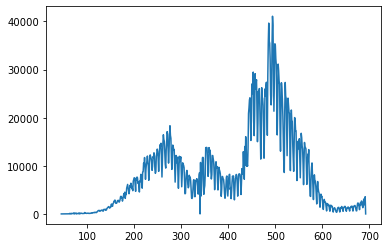

In [22]:
casos_arg=np.array(casos_arg)
nuevos_arg=casos_nuevos(casos_arg)
plt.plot(nuevos_arg)

Elegimos otros 10 países para comparar la k obtenida para Argentina desde el primer caso positivo detectado

In [23]:
def analisis_por_pais(pais):
    ind_pais=np.where(paises==pais)
    ind_pais=ind_pais[0]
    casos_pais=confirmados[ind_pais].dropna()
    dias=np.arange(0,len(casos_pais))
    
    casos_principio_pais=casos_pais[1:60]
    dias_principio=dias[1:60]
    
    #print(f'Pais: {pais}')
    
    plt.figure(figsize = (14,7))
    
    plt.subplot(1,3,1)
    
    plt.plot(dias_principio,casos_principio_pais)
    plt.xlabel('dias')
    plt.ylabel('cantidad de casos')
    plt.title("Cantidad de casos por día")
    
    plt.subplot(1,3,2)
    
    plt.plot(dias_principio,np.log(casos_principio_pais))
    plt.xlabel('dias')
    plt.ylabel('log cantidad de casos')
    plt.title("Log de cantidad de casos por día")
    
    ind_pais =np.where(paises==pais)
    ind_pais=ind_pais[0]
    casos_pais=confirmados[ind_pais].dropna()
    dias=np.arange(0,len(casos_pais))
    
    casos_principio_pais=casos_pais[1:60]
    dias_principio=dias[1:60]
    
    popt, pcov = curve_fit(exponencial, dias_principio, casos_principio_pais)
    #print(popt)
    
    k=popt[0]
    t0=popt[1]
    casos_simu=exponencial(dias_principio,k,t0)
    
    plt.subplot(1,3,3)
    plt.plot(dias_principio,casos_principio_pais,'.')
    plt.plot(dias_principio,casos_simu)
    plt.title("Ajuste con datos reales")


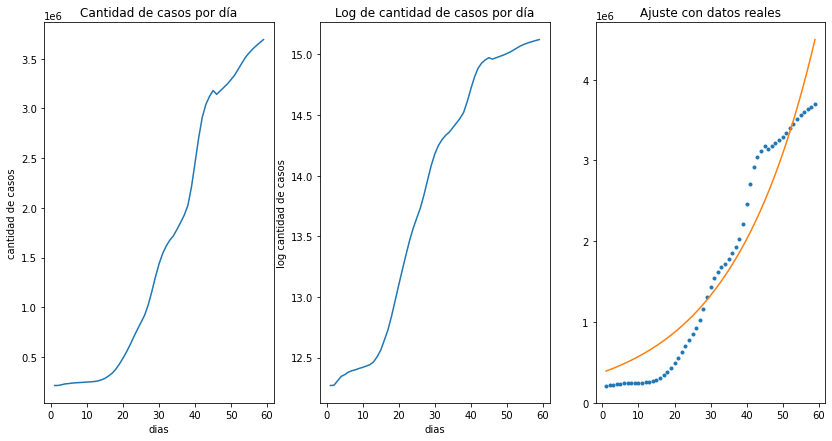

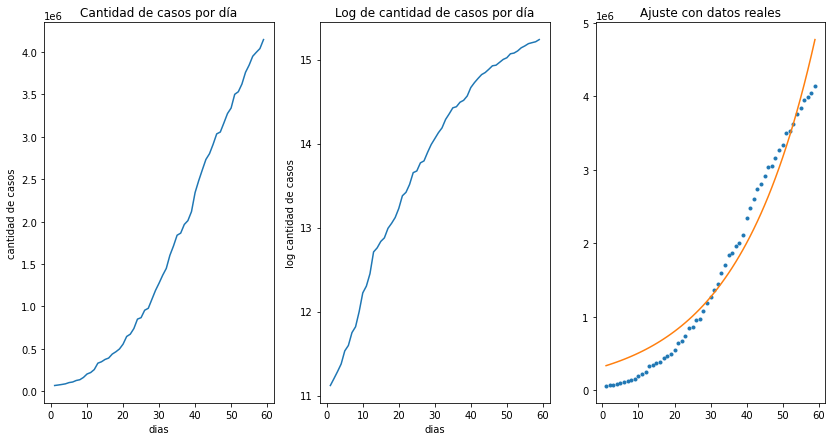

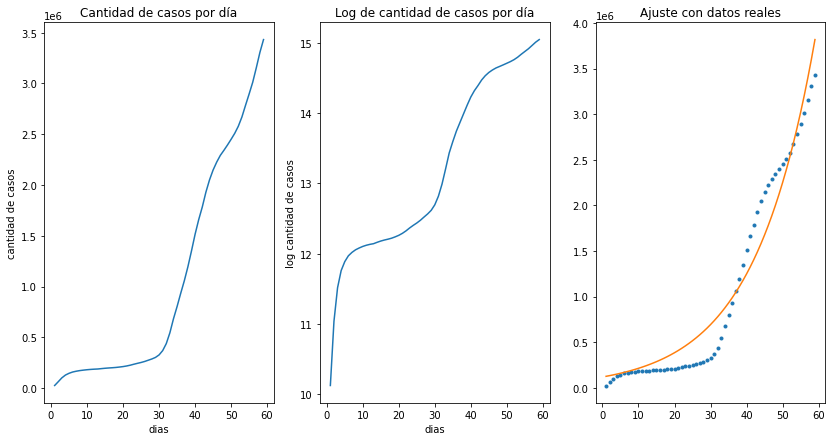

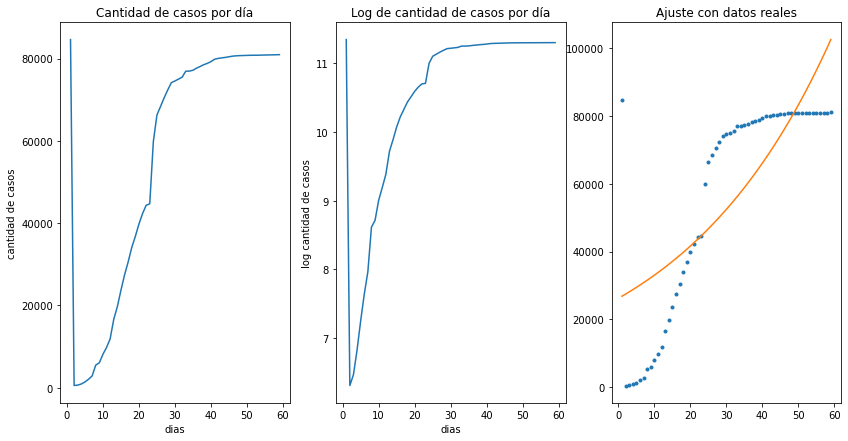

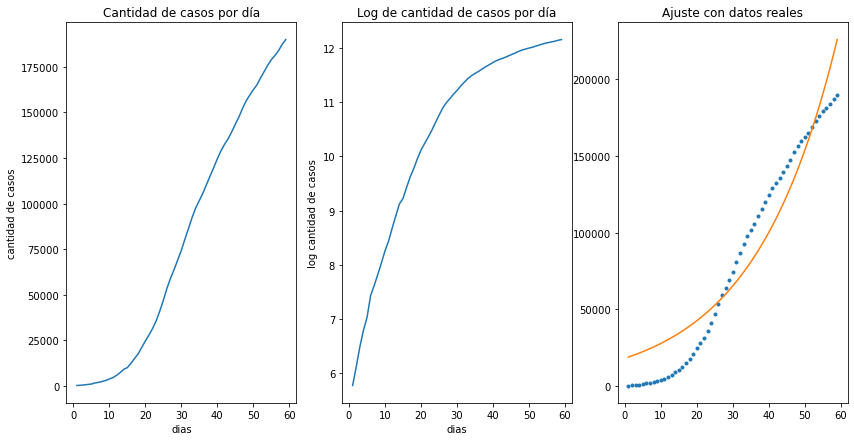

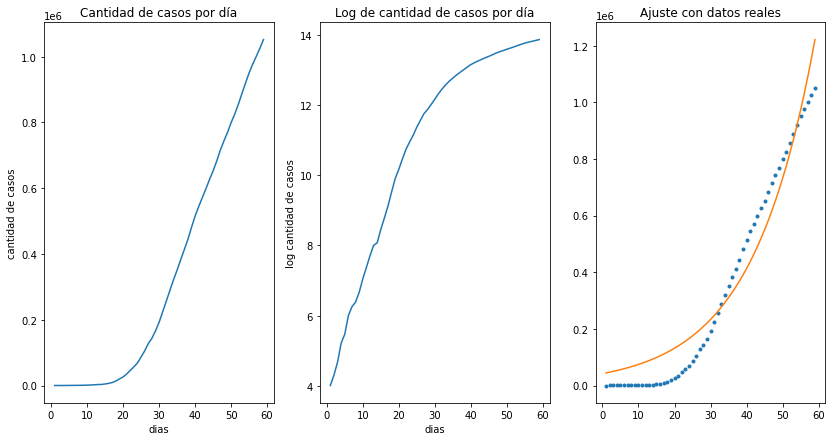

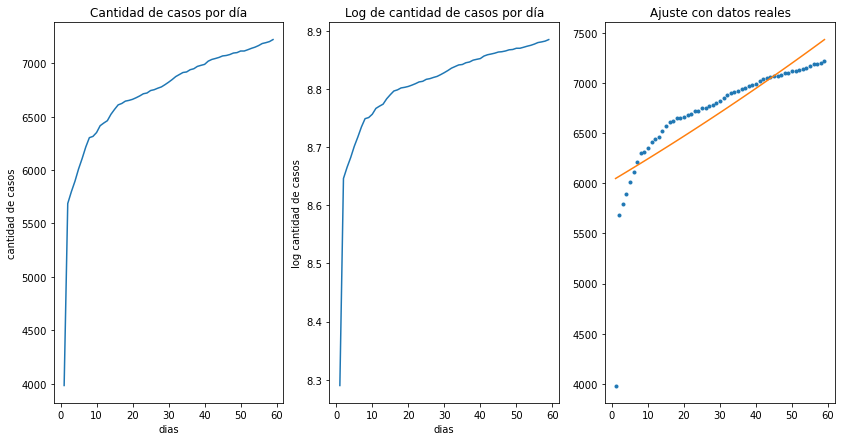

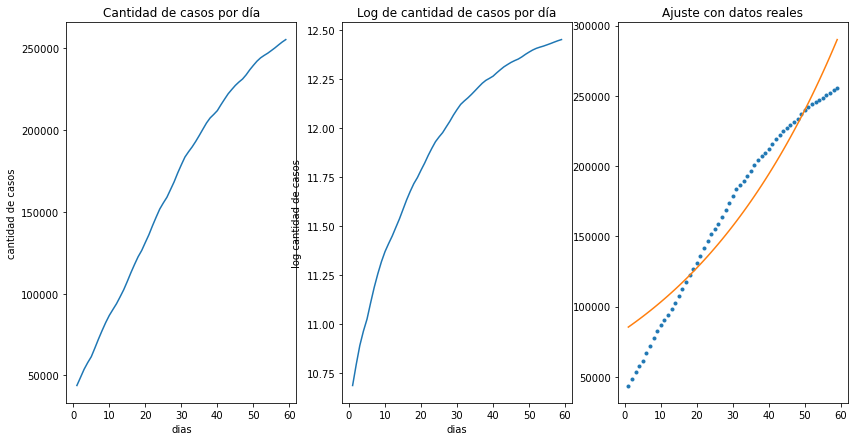

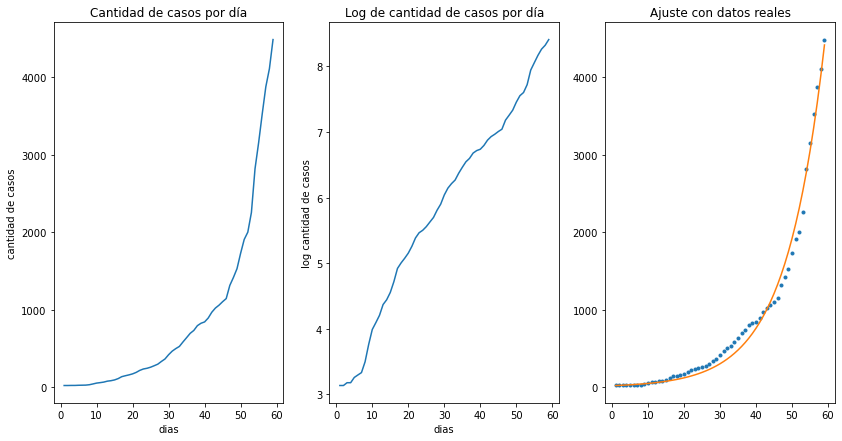

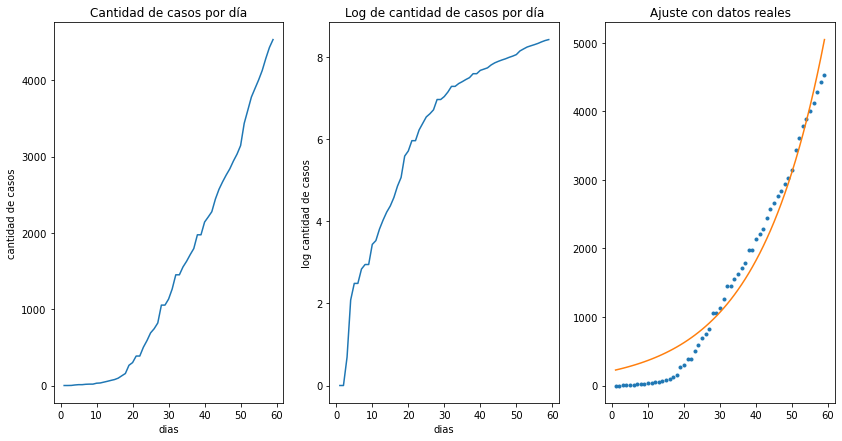

In [24]:
seleccion = ["Spain", "Brazil", "Germany", "China", "Italy", "United States", "Australia","United Kingdom", "Japan", "Argentina"]

for pais in seleccion:
    analisis_por_pais(pais)
    

Análsis de k por países

In [25]:
ind_pais=np.where(paises=="Argentina")
ind_pais=ind_pais[0]
casos_pais=confirmados[ind_pais].dropna()
dias=np.arange(0,len(casos_pais))

casos_principio_pais=casos_pais[0:100]
dias_principio=dias[0:100]
    
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio_pais)
print(popt[0])

0.045780932016629014


In [26]:
# Establecemos una función para calcular el k por países
def k_por_pais(pais, dia_inicio, dia_fin):
    ind_pais=np.where(paises==pais)
    ind_pais=ind_pais[0]
    
    newDF = datos.iloc[ind_pais]
    casos_pais = newDF["Total confirmed cases of COVID-19"]
    
    casos_pais=confirmados[ind_pais].dropna()
    dias=np.arange(0,len(casos_pais))
    
    casos_principio_pais=casos_pais[dia_inicio:dia_fin]
    dias_principio=dias[dia_inicio:dia_fin]
    
    popt, pcov = curve_fit(exponencial, dias_principio, casos_principio_pais, maxfev=1000000)
    #print(popt[0])
    
    return popt[0]

In [27]:
#k_por_pais("Spain",1,100)
#Los países que se consideran son los mismos seleccionados previamente

k_seleccion = []
for pais in seleccion:
    rtdo = k_por_pais(pais,0,100)
     
    k_seleccion.append(rtdo) 

k_seleccion

[0.007940620562553046,
 0.020584380721760706,
 0.013932386390384329,
 0.008714785018157001,
 0.017803265322447033,
 0.025231324852681068,
 0.0038214371964146107,
 0.010541177347792786,
 0.034498010153745116,
 0.045780932016629014]

In [28]:
mu_muestra=np.mean(k_seleccion)
sigma_muestra=np.std(k_seleccion)
print(mu_muestra)
print(sigma_muestra)

0.018884831958256472
0.012473020985753536


In [29]:
# Establecemos un intervalo de confianza con un a=0.05
z=1.96
n=len(k_seleccion)
int_conf=[mu_muestra-z*sigma_muestra/np.sqrt(n),mu_muestra+z*sigma_muestra/np.sqrt(n)]
print(int_conf)

[0.011153973457116755, 0.02661569045939619]


c. Responde: ¿con qué criterio elegiste los países para elaborar el intervalo de confianza k?

Los países se eligieron en función a una selección de distintos países por continente para poder elaborar un intervalo de confianza que recabe información de distintas zonas. Las zonas seleccionadas fueron países de la región como Uruguay y Brasil, de hemisferio norte EEUU, Reino Unido, Italia y España donde la pandemia tuvo mayor impacto y de Asia, donde todo comenzó.

d. Responde: ¿el k promedio que mediste a partir de una población de países, sirve para representar a la población mundial? Justifica 

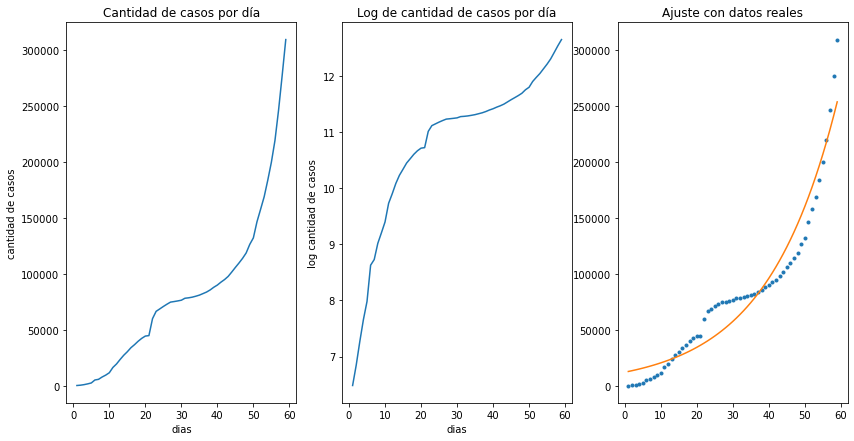

In [30]:
analisis_por_pais("World")

In [31]:
promedio_mundial = k_por_pais("World excl. China",1,100)
promedio_mundial

0.04087084708812196

El k con la base de datos que contiene la información a nivel mundial del dataset arroja un valor de 0,048 que difiere del k de los países seleccionados y queda fuera del intervalo de confianza calculado para un  

e. Realiza al menos dos gráficos que aporten información para el entendimiento e interpretación de los datos

Gráfico que compara la media de k de los países seleccionados y lo compara con el k mundial

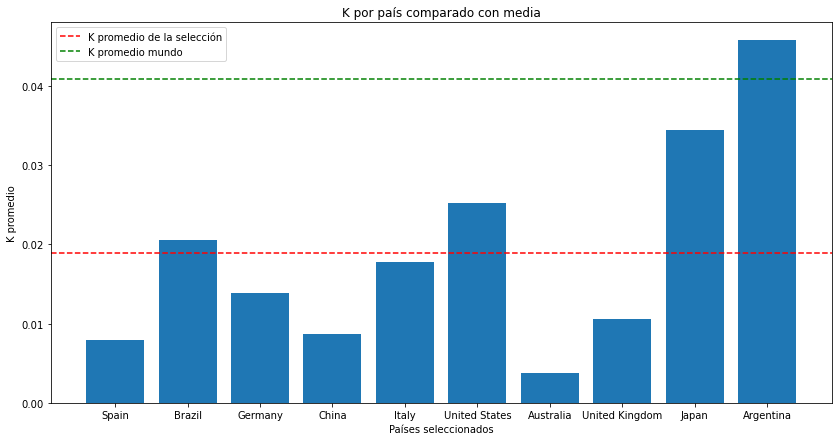

In [32]:
#fig,ax = plt.subplots()
plt.figure(figsize=(14,7))
plt.bar(seleccion, k_seleccion)
plt.axhline(mu_muestra, c = 'r', ls = '--', label = 'K promedio de la selección')
plt.axhline(promedio_mundial, c = 'g', ls = '--', label = 'K promedio mundo')

#ax.set_xticklabels(seleccion)
#fig.autofmt_xdate(rotation=45)
plt.ylabel('K promedio')

plt.xlabel('Países seleccionados')

plt.title('K por país comparado con media')

plt.legend()
plt.show()

Boxplot


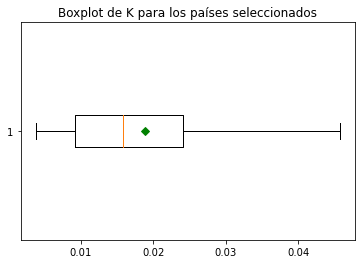

In [33]:
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')

plt.boxplot(x=k_seleccion, vert=False,showmeans=True, meanprops=mean_shape)
plt.title(f"Boxplot de K para los países seleccionados")
plt.show()

 # Evaluando estrategias


Se eligieron tres políticas públicas que se tomaron de la misma web que el dataset original (https://ourworldindata.org/policy-responses-covid). Las políticas seleccionadas fueron:
1. Cierre de fronteras internacionales 
2. Cuarentena estricta
3. Esquema de vacunación

Son políticas tendientes a disminuir la cantidad de casos de COVID y que se han implementado en algún momento de manera general en gran cantidad de países.

https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html


In [10]:
arg =  datos[datos['Entity'] == 'Argentina']
arg.head()

,Entity,Code,Day,total_tests,142601-annotations,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19
4550,Argentina,ARG,2020-01-01,4.0,tests performed,NaN,NaN
4551,Argentina,ARG,2020-01-02,53.0,tests performed,NaN,NaN
4552,Argentina,ARG,2020-01-03,58.0,tests performed,NaN,NaN
4553,Argentina,ARG,2020-01-04,133.0,tests performed,NaN,NaN
4554,Argentina,ARG,2020-01-05,146.0,tests performed,NaN,NaN


In [10]:
arg =  datos[datos['Entity'] == 'Argentina']
arg.head()

,Entity,Code,Day,total_tests,142601-annotations,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19
4550,Argentina,ARG,2020-01-01,4.0,tests performed,NaN,NaN
4551,Argentina,ARG,2020-01-02,53.0,tests performed,NaN,NaN
4552,Argentina,ARG,2020-01-03,58.0,tests performed,NaN,NaN
4553,Argentina,ARG,2020-01-04,133.0,tests performed,NaN,NaN
4554,Argentina,ARG,2020-01-05,146.0,tests performed,NaN,NaN


In [34]:
# Se hace una limpieza de valores nulos 

datos = datos.dropna(subset=['Total confirmed cases of COVID-19'])
#datos = datos.drop(["Code", "total_tests", "142601-annotations", "Total confirmed deaths due to COVID-19"], axis=1)
datos = datos.dropna()
datos

,Entity,Code,Day,total_tests,142601-annotations,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19
1337,Albania,ALB,2020-03-11,157.0,tests performed,1.0,12.0
1338,Albania,ALB,2020-03-12,298.0,tests performed,1.0,23.0
1339,Albania,ALB,2020-03-13,457.0,tests performed,1.0,33.0
1340,Albania,ALB,2020-03-14,505.0,tests performed,1.0,38.0
1341,Albania,ALB,2020-03-15,532.0,tests performed,1.0,42.0
...,...,...,...,...,...,...,...
136116,Zimbabwe,ZWE,2021-12-05,1487999.0,tests performed,4710.0,139046.0
136117,Zimbabwe,ZWE,2021-12-06,1496379.0,tests performed,4710.0,139046.0
136118,Zimbabwe,ZWE,2021-12-07,1507914.0,tests performed,4713.0,141601.0
136119,Zimbabwe,ZWE,2021-12-08,1522080.0,tests performed,4720.0,150628.0


In [35]:
# Se realiza una función que da como resultado una columna de valores binarios que indica con 0 cuando hay una variación diaria positiva de casos (aumentan) y con 1 cuando los casos disminuyen de un día a otro

def casos_binarios(pais):
    
    info = datos[datos.Entity.isin([pais])]
    #info = datos[datos['Entity'] == pais]    
    info = info.dropna()
    
    primero = True

    for index, row in info.iterrows():
        if primero:
            info.loc[index, "Casos por día"] = info.loc[index, "Total confirmed cases of COVID-19"]
            primero = False
        else:
            info.loc[index, "Casos por día"] = info.loc[index, "Total confirmed cases of COVID-19"] - info.loc[index-1, "Total confirmed cases of COVID-19"]

    primero = True

    for index, row in info.iterrows():
        if primero:
            info.loc[index, "Variación casos"] = info.loc[index, "Casos por día"]
            primero = False
        else:
            info.loc[index, "Variación casos"] = info.loc[index, "Casos por día"] - info.loc[index-1, "Casos por día"]
            
    
    for index, row in info.iterrows():
        if info.loc[index, "Variación casos"] > 0:
            info.loc[index, "Binaria"] = 0
        else:
            info.loc[index, "Binaria"] = 1

    return info

In [36]:
# Ejemplo
casos_binarios("Canada")

,Entity,Code,Day,total_tests,142601-annotations,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19,Casos por día,Variación casos,Binaria
21520,Canada,CAN,2020-03-09,3531.0,tests performed,1.0,88.0,88.0,88.0,0.0
21521,Canada,CAN,2020-03-11,4846.0,tests performed,1.0,127.0,39.0,-49.0,1.0
21522,Canada,CAN,2020-03-12,6739.0,tests performed,1.0,141.0,14.0,-25.0,1.0
21523,Canada,CAN,2020-03-13,9889.0,tests performed,1.0,213.0,72.0,58.0,0.0
21524,Canada,CAN,2020-03-14,13209.0,tests performed,1.0,236.0,23.0,-49.0,1.0
...,...,...,...,...,...,...,...,...,...,...
22155,Canada,CAN,2021-12-05,49332335.0,tests performed,29821.0,1815686.0,2382.0,-97.0,1.0
22156,Canada,CAN,2021-12-06,49415557.0,tests performed,29854.0,1820693.0,5007.0,2625.0,0.0
22157,Canada,CAN,2021-12-07,49518440.0,tests performed,29880.0,1823674.0,2981.0,-2026.0,1.0
22158,Canada,CAN,2021-12-08,49600916.0,tests performed,29905.0,1827339.0,3665.0,684.0,0.0


Se agrega una columna con una clasificación binaria para cada política seleccionada   

- Cierre de fronteras

In [37]:
fronteras=pd.read_csv('C:/Users/Admin/Desktop/Data Science/Sprint 4/Sprint Project/international-travel-covid.csv')
fronteras.head()


,Entity,Code,Day,international_travel_controls
0,Afghanistan,AFG,2020-01-01,0
1,Afghanistan,AFG,2020-01-02,0
2,Afghanistan,AFG,2020-01-03,0
3,Afghanistan,AFG,2020-01-04,0
4,Afghanistan,AFG,2020-01-05,0


In [38]:
fronteras.international_travel_controls.unique()

array([0, 3, 1, 2, 4], dtype=int64)

In [39]:
# Identificamos con 1 al cierre completo de fronteras
fronteras = fronteras.replace({3:0,2:0,1:0,4:1})

In [40]:
fronteras.international_travel_controls.unique()

array([0, 1], dtype=int64)

In [41]:
fronteras_arg = fronteras[fronteras['Entity'] == 'Argentina']
#fronteras_arg.drop(['Code', "Entity"], axis=1)
fronteras_arg

,Entity,Code,Day,international_travel_controls
3685,Argentina,ARG,2020-01-01,0
3686,Argentina,ARG,2020-01-02,0
3687,Argentina,ARG,2020-01-03,0
3688,Argentina,ARG,2020-01-04,0
3689,Argentina,ARG,2020-01-05,0
...,...,...,...,...
4416,Argentina,ARG,2022-01-01,0
4417,Argentina,ARG,2022-01-02,0
4418,Argentina,ARG,2022-01-03,0
4419,Argentina,ARG,2022-01-04,0


 - Cuarentena estricta

In [42]:
cuarentena=pd.read_csv('C:/Users/Admin/Desktop/Data Science/Sprint 4/Sprint Project/stay-at-home-covid.csv')
cuarentena.head()

,Entity,Code,Day,stay_home_requirements
0,Afghanistan,AFG,2020-01-01,0
1,Afghanistan,AFG,2020-01-02,0
2,Afghanistan,AFG,2020-01-03,0
3,Afghanistan,AFG,2020-01-04,0
4,Afghanistan,AFG,2020-01-05,0


In [43]:
cuarentena.stay_home_requirements.unique()

array([0, 2, 3, 1], dtype=int64)

In [44]:
# Identificamos con 1 a la cuarentena estricta
cuarentena = cuarentena.replace({2:1,1:0,3:1})
#cuarentena = cuarentena.replace({2:0,0:1,3:0})

In [45]:
cuarentena.stay_home_requirements.unique()

array([0, 1], dtype=int64)

In [46]:
cuarentena_arg = cuarentena[cuarentena['Entity'] == 'Argentina']
#fronteras_arg.drop(['Code', "Entity"], axis=1)
cuarentena_arg

,Entity,Code,Day,stay_home_requirements
3684,Argentina,ARG,2020-01-01,0
3685,Argentina,ARG,2020-01-02,0
3686,Argentina,ARG,2020-01-03,0
3687,Argentina,ARG,2020-01-04,0
3688,Argentina,ARG,2020-01-05,0
...,...,...,...,...
4415,Argentina,ARG,2022-01-01,0
4416,Argentina,ARG,2022-01-02,0
4417,Argentina,ARG,2022-01-03,0
4418,Argentina,ARG,2022-01-04,0


 - Esquema de vacunación
 
Countries are grouped into six categories:

0- No availability 

1- Availability for ONE of following: key workers/ clinically vulnerable groups / elderly groups

2- Availability for TWO of following: key workers/ clinically vulnerable groups / elderly groups

3- Availability for ALL of following: key workers/ clinically vulnerable groups / elderly groups

4- Availability for all three plus partial additional availability (select broad groups/ages)

5- Universal availability

In [47]:
vacunacion=pd.read_csv('C:/Users/Admin/Desktop/Data Science/Sprint 4/Sprint Project/covid-vaccination-policy.csv')
vacunacion.head()

,Entity,Code,Day,vaccination_policy
0,Afghanistan,AFG,2020-01-01,0
1,Afghanistan,AFG,2020-01-02,0
2,Afghanistan,AFG,2020-01-03,0
3,Afghanistan,AFG,2020-01-04,0
4,Afghanistan,AFG,2020-01-05,0


In [48]:
vacunacion.vaccination_policy.unique()

array([0, 2, 1, 3, 4, 5], dtype=int64)

In [49]:
# Identificamos con 1 a las categorías 3, 4 y 5
vacunacion = vacunacion.replace({3:1,2:0,1:0,4:1,5:1})

In [50]:
vacunacion.vaccination_policy.unique()

array([0, 1], dtype=int64)

Unimos los datasets para formar uno único

In [51]:
dataset = pd.merge(datos, fronteras, on=["Day", "Entity", "Code"])
dataset

,Entity,Code,Day,total_tests,142601-annotations,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19,international_travel_controls
0,Albania,ALB,2020-03-11,157.0,tests performed,1.0,12.0,0
1,Albania,ALB,2020-03-12,298.0,tests performed,1.0,23.0,0
2,Albania,ALB,2020-03-13,457.0,tests performed,1.0,33.0,0
3,Albania,ALB,2020-03-14,505.0,tests performed,1.0,38.0,0
4,Albania,ALB,2020-03-15,532.0,tests performed,1.0,42.0,0
...,...,...,...,...,...,...,...,...
54784,Zimbabwe,ZWE,2021-12-05,1487999.0,tests performed,4710.0,139046.0,0
54785,Zimbabwe,ZWE,2021-12-06,1496379.0,tests performed,4710.0,139046.0,0
54786,Zimbabwe,ZWE,2021-12-07,1507914.0,tests performed,4713.0,141601.0,0
54787,Zimbabwe,ZWE,2021-12-08,1522080.0,tests performed,4720.0,150628.0,0


In [52]:
dataset = pd.merge(dataset, cuarentena, on=["Day", "Entity", "Code"])
dataset

,Entity,Code,Day,total_tests,142601-annotations,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19,international_travel_controls,stay_home_requirements
0,Albania,ALB,2020-03-11,157.0,tests performed,1.0,12.0,0,0
1,Albania,ALB,2020-03-12,298.0,tests performed,1.0,23.0,0,0
2,Albania,ALB,2020-03-13,457.0,tests performed,1.0,33.0,0,1
3,Albania,ALB,2020-03-14,505.0,tests performed,1.0,38.0,0,1
4,Albania,ALB,2020-03-15,532.0,tests performed,1.0,42.0,0,1
...,...,...,...,...,...,...,...,...,...
54710,Zimbabwe,ZWE,2021-12-05,1487999.0,tests performed,4710.0,139046.0,0,1
54711,Zimbabwe,ZWE,2021-12-06,1496379.0,tests performed,4710.0,139046.0,0,1
54712,Zimbabwe,ZWE,2021-12-07,1507914.0,tests performed,4713.0,141601.0,0,1
54713,Zimbabwe,ZWE,2021-12-08,1522080.0,tests performed,4720.0,150628.0,0,1


In [53]:
dataset = pd.merge(dataset, vacunacion, on=["Day", "Entity", "Code"])
dataset

,Entity,Code,Day,total_tests,142601-annotations,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19,international_travel_controls,stay_home_requirements,vaccination_policy
0,Albania,ALB,2020-03-11,157.0,tests performed,1.0,12.0,0,0,0
1,Albania,ALB,2020-03-12,298.0,tests performed,1.0,23.0,0,0,0
2,Albania,ALB,2020-03-13,457.0,tests performed,1.0,33.0,0,1,0
3,Albania,ALB,2020-03-14,505.0,tests performed,1.0,38.0,0,1,0
4,Albania,ALB,2020-03-15,532.0,tests performed,1.0,42.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
54600,Zimbabwe,ZWE,2021-12-05,1487999.0,tests performed,4710.0,139046.0,0,1,1
54601,Zimbabwe,ZWE,2021-12-06,1496379.0,tests performed,4710.0,139046.0,0,1,1
54602,Zimbabwe,ZWE,2021-12-07,1507914.0,tests performed,4713.0,141601.0,0,1,1
54603,Zimbabwe,ZWE,2021-12-08,1522080.0,tests performed,4720.0,150628.0,0,1,1


In [54]:
#alb = dataset[dataset['Entity'] == "Argentina" or "Chile"]
#alb
values=["Argentina","Chile"]
filtered_df = dataset[dataset.Entity.isin(values)]
filtered_df

,Entity,Code,Day,total_tests,142601-annotations,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19,international_travel_controls,stay_home_requirements,vaccination_policy
508,Argentina,ARG,2020-03-08,716.0,tests performed,1.0,12.0,0,0,0
509,Argentina,ARG,2020-03-09,730.0,tests performed,1.0,12.0,0,0,0
510,Argentina,ARG,2020-03-10,767.0,tests performed,1.0,17.0,0,0,0
511,Argentina,ARG,2020-03-11,802.0,tests performed,1.0,19.0,0,0,0
512,Argentina,ARG,2020-03-12,849.0,tests performed,1.0,19.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7808,Chile,CHL,2021-12-05,25709328.0,tests performed,38501.0,1772547.0,1,0,1
7809,Chile,CHL,2021-12-06,25769327.0,tests performed,38531.0,1774048.0,1,0,1
7810,Chile,CHL,2021-12-07,25810794.0,tests performed,38535.0,1775212.0,1,0,1
7811,Chile,CHL,2021-12-08,25862441.0,tests performed,38541.0,1776599.0,1,0,1


Modelo

In [55]:
pais_modelo1 = "Italy"

dataset_modelo1 = dataset[dataset.Entity.isin([pais_modelo1])]   
dataset_modelo1                       
a1 = casos_binarios(pais_modelo1)

modelo1 = pd.merge(dataset_modelo1, a1, on=["Day", "Entity", "Code"])
modelo1 = modelo1.loc[:,['international_travel_controls',"stay_home_requirements",'vaccination_policy', "Binaria"]]
modelo1

,international_travel_controls,stay_home_requirements,vaccination_policy,Binaria
0,0,1,0,0.0
1,0,1,0,1.0
2,0,1,0,0.0
3,0,1,0,0.0
4,0,1,0,0.0
...,...,...,...,...
649,0,1,1,1.0
650,0,1,1,1.0
651,0,1,1,0.0
652,0,1,1,0.0


In [56]:
pais_modelo2 = "United Kingdom"

dataset_modelo2 = dataset[dataset.Entity.isin([pais_modelo2])]   
dataset_modelo2                       
a2 = casos_binarios(pais_modelo2)

modelo2= pd.merge(dataset_modelo2, a2, on=["Day", "Entity", "Code"])
modelo2 = modelo2.loc[:,['international_travel_controls',"stay_home_requirements",'vaccination_policy', "Binaria"]]
modelo2

,international_travel_controls,stay_home_requirements,vaccination_policy,Binaria
0,0,1,0,0.0
1,0,1,0,1.0
2,0,1,0,1.0
3,0,1,0,0.0
4,0,1,0,1.0
...,...,...,...,...
613,0,0,1,1.0
614,0,0,1,0.0
615,0,0,1,0.0
616,0,0,1,1.0


In [57]:
pais_modelo3 = "Argentina"

dataset_modelo3 = dataset[dataset.Entity.isin([pais_modelo3])]   
dataset_modelo3                       
a3 = casos_binarios(pais_modelo3)

modelo3= pd.merge(dataset_modelo3, a3, on=["Day", "Entity", "Code"])
modelo3= modelo3.loc[:,['international_travel_controls',"stay_home_requirements",'vaccination_policy', "Binaria"]]
modelo3

,international_travel_controls,stay_home_requirements,vaccination_policy,Binaria
0,0,0,0,0.0
1,0,0,0,1.0
2,0,0,0,0.0
3,0,0,0,1.0
4,0,0,0,1.0
...,...,...,...,...
632,0,0,1,0.0
633,0,0,1,1.0
634,0,0,1,0.0
635,0,0,1,1.0


In [58]:
pais_modelo4 = "Portugal"

dataset_modelo4 = dataset[dataset.Entity.isin([pais_modelo4])]   
dataset_modelo4                       
a4 = casos_binarios(pais_modelo4)

modelo4= pd.merge(dataset_modelo4, a4, on=["Day", "Entity", "Code"])
modelo4= modelo4.loc[:,['international_travel_controls',"stay_home_requirements",'vaccination_policy', "Binaria"]]
modelo4

,international_travel_controls,stay_home_requirements,vaccination_policy,Binaria
0,0,0,0,0.0
1,0,0,0,1.0
2,0,1,0,0.0
3,0,1,0,1.0
4,0,1,0,0.0
...,...,...,...,...
627,0,0,1,0.0
628,0,0,1,1.0
629,0,0,1,1.0
630,0,0,1,0.0


In [59]:
pais_modelo5 = "Uruguay"

dataset_modelo5 = dataset[dataset.Entity.isin([pais_modelo5])]   
dataset_modelo5                       
a5 = casos_binarios(pais_modelo5)

modelo5= pd.merge(dataset_modelo5, a5, on=["Day", "Entity", "Code"])
modelo5= modelo5.loc[:,['international_travel_controls',"stay_home_requirements",'vaccination_policy', "Binaria"]]
modelo5

,international_travel_controls,stay_home_requirements,vaccination_policy,Binaria
0,1,0,0,0.0
1,1,0,0,1.0
2,1,0,0,0.0
3,1,0,0,0.0
4,1,0,0,1.0
...,...,...,...,...
617,0,0,1,1.0
618,0,0,1,0.0
619,0,0,1,0.0
620,0,0,1,0.0


In [60]:
modelo = pd.concat([modelo1, modelo2, modelo3, modelo4, modelo5], axis=0)
modelo

,international_travel_controls,stay_home_requirements,vaccination_policy,Binaria
0,0,1,0,0.0
1,0,1,0,1.0
2,0,1,0,0.0
3,0,1,0,0.0
4,0,1,0,0.0
...,...,...,...,...
617,0,0,1,1.0
618,0,0,1,0.0
619,0,0,1,0.0
620,0,0,1,0.0


In [61]:
X_train, X_test, y_train, y_test = train_test_split(modelo.drop("Binaria", axis=1), modelo["Binaria"], test_size=0.3, random_state=0)

In [62]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [63]:
# Predicting if international_travel_controls = 1, stay_home_requirements=1, vaccination_policy=1
y_pred = logreg.predict(np.array([[0,0,1]]))[0]
y_pred

1.0

In [64]:
y_pred=logreg.predict(X_test)
y_pred

array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
       1., 1., 1., 0., 0.

In [65]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.53


In [66]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[209 232]
 [218 290]]


Text(0.5, 257.44, 'Predicted label')

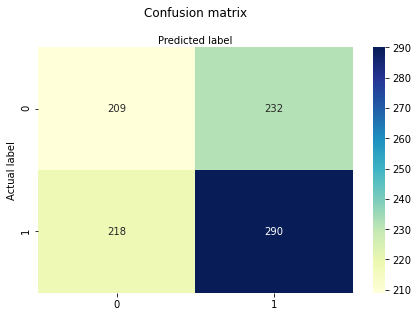

In [67]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [68]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.5258166491043204
Precision: 0.5555555555555556
Recall: 0.5708661417322834


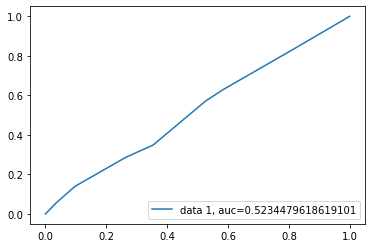

In [69]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [70]:
importances = pd.DataFrame(data={'Attribute': X_train.columns,'Importance': logreg.coef_[0]})
importances = importances.sort_values(by='Importance', ascending=False)

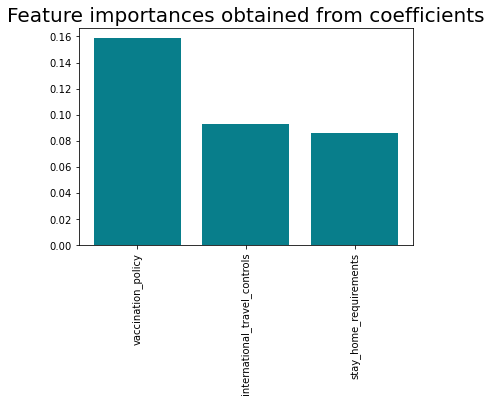

In [71]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

 # Investigación
 
#### Plantea nuevas preguntas en base al trabajo que hiciste y en las que se puede ahondar. 


En base al trabajo realizado surgen varias interrogantes que podrían analizarse en profundidad y que podrían ser útiles para el modelo de regresión.

Una de las dudas que surgen es si al aplicar más políticas públicas a la hora de entrenar el modelo se hubiera mejorado el Accuracy. 

También se podría analizar con mayor profundidad si se realizó una correcta elección de los países a utilizar en el trabajo o se podría haber realizado una mejor combinación. 

Además de las políticas públicas aplicadas por los distintos países se podría analizar el acatamiento a las mismas como una variable más, porque si no se cumplen con las medidas establecidas no van a tener efecto en el objetico final que es controlar que aumenten los casos de COVID.

Se puede aplicar un análisis de series de tiempo para ver la evolución de los casos por día y en todo caso predecir la evolución a futuro a través de un modelo de predicción. A continuación se desarrolla el inicio de la transformación de datos para una serie de tiempo.

In [72]:
dataset_argentina = casos_binarios("Argentina")
dataset_argentina

,Entity,Code,Day,total_tests,142601-annotations,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19,Casos por día,Variación casos,Binaria
4600,Argentina,ARG,2020-03-08,716.0,tests performed,1.0,12.0,12.0,12.0,0.0
4601,Argentina,ARG,2020-03-09,730.0,tests performed,1.0,12.0,0.0,-12.0,1.0
4602,Argentina,ARG,2020-03-10,767.0,tests performed,1.0,17.0,5.0,5.0,0.0
4603,Argentina,ARG,2020-03-11,802.0,tests performed,1.0,19.0,2.0,-3.0,1.0
4604,Argentina,ARG,2020-03-12,849.0,tests performed,1.0,19.0,0.0,-2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
5232,Argentina,ARG,2021-11-30,26281626.0,tests performed,116589.0,5330748.0,2332.0,364.0,0.0
5233,Argentina,ARG,2021-12-01,26323470.0,tests performed,116597.0,5332629.0,1881.0,-451.0,1.0
5234,Argentina,ARG,2021-12-02,26366291.0,tests performed,116617.0,5335310.0,2681.0,800.0,0.0
5235,Argentina,ARG,2021-12-03,26402277.0,tests performed,116639.0,5337692.0,2382.0,-299.0,1.0


In [73]:
import datetime

In [74]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_argentina['Fecha'] = pd.to_datetime(dataset_argentina.Day)

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_argentina.drop(columns=['Day'], inplace = True)

dataset_argentina.head()

,Entity,Code,total_tests,142601-annotations,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19,Casos por día,Variación casos,Binaria,Fecha
4600,Argentina,ARG,716.0,tests performed,1.0,12.0,12.0,12.0,0.0,2020-03-08
4601,Argentina,ARG,730.0,tests performed,1.0,12.0,0.0,-12.0,1.0,2020-03-09
4602,Argentina,ARG,767.0,tests performed,1.0,17.0,5.0,5.0,0.0,2020-03-10
4603,Argentina,ARG,802.0,tests performed,1.0,19.0,2.0,-3.0,1.0,2020-03-11
4604,Argentina,ARG,849.0,tests performed,1.0,19.0,0.0,-2.0,1.0,2020-03-12


In [75]:
#Reordenamos el dataset por fecha
dataset_argentina.sort_values('Fecha', inplace = True)
dataset_argentina.reset_index(drop=True, inplace = True)
dataset_argentina

,Entity,Code,total_tests,142601-annotations,Total confirmed deaths due to COVID-19,Total confirmed cases of COVID-19,Casos por día,Variación casos,Binaria,Fecha
0,Argentina,ARG,716.0,tests performed,1.0,12.0,12.0,12.0,0.0,2020-03-08
1,Argentina,ARG,730.0,tests performed,1.0,12.0,0.0,-12.0,1.0,2020-03-09
2,Argentina,ARG,767.0,tests performed,1.0,17.0,5.0,5.0,0.0,2020-03-10
3,Argentina,ARG,802.0,tests performed,1.0,19.0,2.0,-3.0,1.0,2020-03-11
4,Argentina,ARG,849.0,tests performed,1.0,19.0,0.0,-2.0,1.0,2020-03-12
...,...,...,...,...,...,...,...,...,...,...
632,Argentina,ARG,26281626.0,tests performed,116589.0,5330748.0,2332.0,364.0,0.0,2021-11-30
633,Argentina,ARG,26323470.0,tests performed,116597.0,5332629.0,1881.0,-451.0,1.0,2021-12-01
634,Argentina,ARG,26366291.0,tests performed,116617.0,5335310.0,2681.0,800.0,0.0,2021-12-02
635,Argentina,ARG,26402277.0,tests performed,116639.0,5337692.0,2382.0,-299.0,1.0,2021-12-03


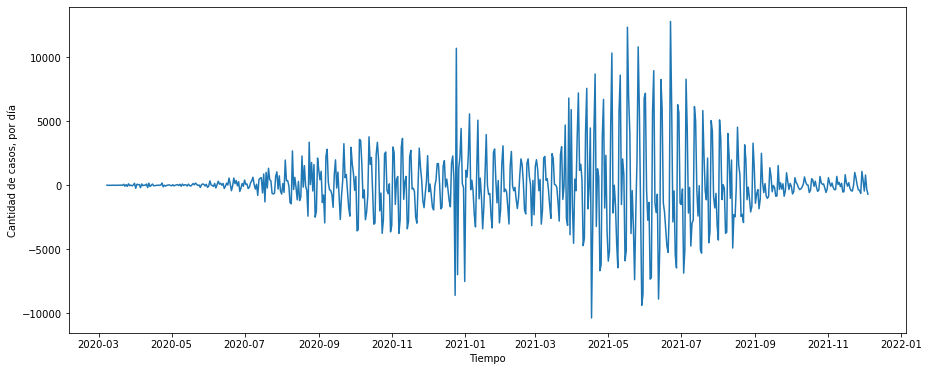

In [76]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset_argentina.Fecha, dataset_argentina["Variación casos"])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de casos, por día')
plt.show()

####  Elabora un informe con todo lo que hiciste

El trabajo realizado se dividió en dos grandes secciones, la de exploración de datos que incluye la medición de k y la de evaluación de estrategias.


En la primer sección se realizó un análisis exploratorio de datos para investigar el dataset y comprender que indica cada columna. Para llevar a cabo esta tarea se tomaron los datos de Argentina y se buscaron datos faltantes para la columna de casos totales confirmados, realizando el ajuste correspondiente para poder avanzar con el trabajo. 
A través de distintos gráficos se buscó en qué momento se produce el crecimiento exponencial de casos y con esto se calculó el k para el país.

Una vez determinado el k para Argentina, se realizó una selección de más países para determinar el k de cada uno de ellos y establecer así la media de esta muestra de k. Esto nos permite definir un intervalo de confianza con un a=0,05.
Por último se compara el k promedio con el k para el mundo, para ello se grafica para una mejor comprensión de la información.

Estas fueron las tareas realizadas para la primer sección. Una vez finalizado se avanzó con la segunda sección de evaluación de estrategias.

Esta segunda parte requirió un relevamiento de información fuera del dataset original para identificar las políticas públicas que fueron implementadas por los distintos países, investigar cuáles de estas políticas podían ser más útiles para el objetivo buscado y seleccionar los países que se consideran más representativos. 
Se procedió a realizar una función que determine los casos confirmados por día ya que el dataset acumulaba los casos. Una vez con esta nueva columna en el dataset se agrega una nueva columna con datos binarios que indican si hubo un aumento o una disminución de los casos día a día.
Con las políticas públicas a utilizar definidas, se vuelve a aplicar una función que realiza una clasificación binaria sobre si se aplica o no la política pública.
Así se obtiene un nuevo dataset que es útil para elaborar un modelo de regresión seleccionando ciertos países para el entrenamiento del mismo. Se establece un código para implementarlo y se evalúa su rendimiento.
Se fueron probando distintas alternativas para ir mejorando el modelo.

 # Requerimientos adicionales
 
 Busca información en la web para completar la información. Recuerda especificar las fuentes de la información en el informe.
 
 Analiza en detalle los resultados que obtienes a medida que vas completando el notebook. Piensa en una interpretación epidemiológica de cada cosa y explicítala justificando con detalle al hacer el informe. La interpretación del trabajo es tan crucial como la realización de los códigos que sirvan para hacer el análisis.
 
 Estos requerimientos se fueron completando a medida que se realiza el trabajo.